In [12]:
%load_ext autoreload
%autoreload 2


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
import os
import time

from scipy.stats import t

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
#to view entire text of the comuns
pd.set_option('display.max_colwidth', None) 

import sklearn as sk

import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

from IPython.display import clear_output

import pickle


from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
import imblearn.under_sampling as resus
import imblearn.ensemble as resemb
import imblearn.combine as reshyb
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

from itertools import combinations
from math import factorial



%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create instances for the models having the best performance

In [3]:
best_classifiers = []

# Decision Tree,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.81,0.57,0.94,0.82,0.4,
estimator = DecisionTreeClassifier(class_weight='balanced',max_depth=4,random_state=42)
dt_ei = BalancedBaggingClassifier(
    estimator=estimator,
#     ':DecisionTreeClassifier(class_weight='balanced',max_depth=4,random_state=42),
    **{'n_estimators':7,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':True}
)
best_classifiers.append(['Decision Tree (EI)', 'Ensemble-Imbalance', dt_ei])


# Neural Networks,Ensemble-Imbalance,All Features,Balanced Bagging,0.88,0.96,0.8,0.56,0.93,0.82,0.39,
estimator = MLPClassifier(activation='tanh',alpha=0.1,hidden_layer_sizes=30,learning_rate='adaptive',learning_rate_init=0.7,max_iter=2000,random_state=42)
nn_ei = BalancedBaggingClassifier(
    estimator=estimator,
    **{'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'auto','warm_start':False}
)
best_classifiers.append(['Neural Networks (EI)', 'Ensemble-Imbalance', nn_ei])


# Random Forest,Ensemble-Imbalance,All Features,Balanced Random Forest,0.87,0.96,0.79,0.55,0.93,0.81,0.38,
rf_ei = BalancedRandomForestClassifier(
    **{'criterion':'entropy','max_depth':7,'n_estimators':19,'random_state':42,'replacement':True,
       'sampling_strategy':'auto','warm_start':False}
)
best_classifiers.append(['Random Forest (EI)', 'Ensemble-Imbalance', rf_ei])

# SVM,Ensemble-Imbalance,All Features,Balanced Bagging,0.87,0.94,0.81,0.56,0.93,0.82,0.4,
estimator = SVC(C=3,class_weight='balanced',gamma='auto',probability=True,random_state=42)
svm_ei = BalancedBaggingClassifier(
    estimator=estimator,
    **{'n_estimators':51,'random_state':42,'replacement':False,'sampling_strategy':'auto','warm_start':True}
)
best_classifiers.append(['SVM (EI)', 'Ensemble-Imbalance', svm_ei])


# SVM,Single-Model,All Features,SVM,0.87,0.94,0.8,0.54,0.93,0.81,0.38,
svm_sm = SVC(
    **{'C':0.3,'class_weight':'balanced','gamma':'auto','kernel':'rbf','probability':True,'random_state':42}
)
best_classifiers.append(['SVM (SM)', 'Single-Model', svm_sm])

# Random Forest,Single-Model,All Features,Random Forest,0.87,0.89,0.86,0.6,0.92,0.86,0.46,
rf_sm = RandomForestClassifier(
    **{'class_weight':'balanced','criterion':'gini','max_depth':5,'n_estimators':51,'random_state':42}
)

best_classifiers.append(['Random Forest (SM)', 'Single-Model', rf_sm])


# Neural Networks,Single-Model,All Features,Neural Networks,0.87,0.87,0.87,0.61,0.94,0.87,0.47,
nn_sm = MLPClassifier(
    **{'activation':'tanh','alpha':0.3,'hidden_layer_sizes':(23,23,23),'learning_rate':'constant',
       'learning_rate_init':0.7,'max_iter':2000,'random_state':42,'solver':'sgd'}
)
best_classifiers.append(['Neural Networks (SM)', 'Single-Model', nn_sm])

# k-NN,Ensemble-Imbalance,All Features,Balanced Bagging,0.85,0.85,0.85,0.57,0.9,0.85,0.43,
estimator = KNeighborsClassifier(metric='euclidean',weights='distance')
knn_ei = BalancedBaggingClassifier(
    estimator=estimator,
    **{'n_estimators':101,'random_state':42,'replacement':True,'sampling_strategy':'all',
       'warm_start':True}
)
best_classifiers.append(['k-NN (EI)', 'Ensemble-Imbalance', knn_ei])

# Naïve Bayes,Ensemble-Imbalance,All Features,Balanced Bagging,0.84,0.85,0.83,0.54,0.9,0.83,0.4
estimator = GaussianNB()
nb_ei = BalancedBaggingClassifier(
    estimator = estimator,
    **{'n_estimators':31,'random_state':42,'replacement':True,'sampling_strategy':'all','warm_start':False}
)
best_classifiers.append(['Naïve Bayes (EI)', 'Ensemble-Imbalance', nb_ei])


# Decision Tree,Single-Model,All Features,Decision Tree,0.83,0.85,0.81,0.53,0.88,0.82,0.38,
dt_sm = DecisionTreeClassifier(
    **{'class_weight':'balanced','criterion':'gini','max_depth':4,'random_state':42}
)
best_classifiers.append(['Decision Tree (SM)', 'Single-Model', dt_sm])


# Naïve Bayes,Single-Model,All Features,Naïve Bayes,0.8,0.74,0.86,0.53,0.9,0.84,0.41,
nb_sm = GaussianNB()
best_classifiers.append(['Naïve Bayes (SM)', 'Single-Model', nb_sm])

# k-NN,Single-Model,All Features,k-NN,0.68,0.4,0.96,0.48,0.81,0.9,0.59,
knn_sm = KNeighborsClassifier(
    **{'metric':'manhattan','n_neighbors':3,'weights':'uniform'}
)
best_classifiers.append(['k-NN (SM)', 'Single-Model', knn_sm])


# best_classifiers





# Fit the models using CV and Training Data

In [7]:
%%time

CV_N_SPLITS = 5
CV_N_REPEATS = 3
RANDOM_STATE = 42

# CV strategy
cv = sk.model_selection.RepeatedStratifiedKFold(
    n_splits=CV_N_SPLITS, 
    n_repeats=CV_N_REPEATS, 
    random_state=RANDOM_STATE
)

# get train and tezt sets INCLUDING the Diagnosis_Delay feature
X_train, y_train, X_valid, y_valid = utils.get_train_and_validation_data(
    scaled=True,
    use_diagnosis_delay=True,
)

X_all = pd.concat([X_train, X_valid])
y_all = pd.concat([y_train, y_valid])


params = [
    {'classifier': [dt_ei]},
    {'classifier': [dt_sm]},
    {'classifier': [nn_ei]},
    {'classifier': [nn_sm]},
    {'classifier': [rf_ei]},
    {'classifier': [rf_sm]},
    {'classifier': [svm_ei]},
    {'classifier': [svm_sm]},
    {'classifier': [nb_ei]},
    {'classifier': [nb_sm]},
    {'classifier': [knn_ei]},
    {'classifier': [knn_ei]},
]

# auxiliary class
class DummyEstimator(sk.base.BaseEstimator):
        def fit(self): pass
        def score(self): pass
        
        
# Create a pipeline
# pipe = sk.pipeline.Pipeline([('classifier', DummyEstimator())])

pipeline = sk.pipeline.Pipeline(steps=[('classifier', GaussianNB() )])


grid = sk.model_selection.GridSearchCV(
    pipeline, 
    param_grid=params, 
    scoring=utils_exec_models_new.get_default_scoring(), 
    cv=cv,
    n_jobs=9,
    verbose=1,
    refit='balanced_accuracy', 
)


# fit using only trainning set
grid.fit(X_train, y_train.values.ravel())
cv_results_trainning = grid.cv_results_


# fit using only ALL database
grid.fit(X_all, y_all.values.ravel())
cv_results_all = grid.cv_results_


Fitting 15 folds for each of 12 candidates, totalling 180 fits
Fitting 15 folds for each of 12 candidates, totalling 180 fits
CPU times: user 2.78 s, sys: 78.2 ms, total: 2.86 s
Wall time: 37.3 s


# 1) Create dataFrame with the all "cv_results_" of all algorithm and scenarios

In [8]:
algorithms = [
    'Decision Tree (EI)',
    'Decision Tree',
    'Neural Networks (EI)',
    'Neural Networks',
    'Random Forest (EI)',
    'Random Forest',
    'SVM (EI)',
    'SVM',
    'Naïve Bayes (EI)',
    'Naïve Bayes',
    'k-NN (EI)',
    'k-NN',
]

# trainning
df_results_trainning = pd.DataFrame(cv_results_trainning)
df_results_trainning.insert(0, 'Algorithm', algorithms)


# all database
df_results_all = pd.DataFrame(cv_results_all)
df_results_all.insert(0, 'Algorithm', algorithms)


display(df_results_trainning.head(3))
display(df_results_all.head(3))


,Algorithm,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,...,split8_test_precision,split9_test_precision,split10_test_precision,split11_test_precision,split12_test_precision,split13_test_precision,split14_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,Decision Tree (EI),0.045735,0.010532,0.021784,0.003743,"BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',\n max_depth=4,\n random_state=42),\n n_estimators=7, random_state=42, replacement=True,\n sampling_strategy='all', warm_start=True)","{'classifier': BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42), n_estimators=7, random_state=42, replacement=True, sampling_strategy='all', warm_start=True)}",0.789790,0.780087,0.745327,...,0.405797,0.436620,0.376623,0.397260,0.397260,0.483871,0.378378,0.406411,0.031863,9
1,Decision Tree,0.006179,0.001273,0.019688,0.004604,"DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)","{'classifier': DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)}",0.801495,0.770963,0.703267,...,0.302752,0.263636,0.348485,0.394366,0.317308,0.330097,0.300971,0.332035,0.029886,11
2,Neural Networks (EI),4.195905,0.874436,0.070121,0.009217,"BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1,\n hidden_layer_sizes=30,\n learning_rate='adaptive',\n learning_rate_init=0.7,\n max_iter=2000,\n random_state=42),\n n_estimators=101, random_state=42, replacement=True)","{'classifier': BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=30, learning_rate='adaptive', learning_rate_init=0.7, max_iter=2000, random_state=42), n_estimators=101, random_state=42, replacement=True)}",0.847116,0.837992,0.764821,...,0.455696,0.430380,0.441558,0.390244,0.395062,0.514706,0.407895,0.423085,0.040160,6


,Algorithm,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_balanced_accuracy,split1_test_balanced_accuracy,split2_test_balanced_accuracy,...,split8_test_precision,split9_test_precision,split10_test_precision,split11_test_precision,split12_test_precision,split13_test_precision,split14_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,Decision Tree (EI),0.041011,0.006922,0.021026,0.003808,"BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',\n max_depth=4,\n random_state=42),\n n_estimators=7, random_state=42, replacement=True,\n sampling_strategy='all', warm_start=True)","{'classifier': BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42), n_estimators=7, random_state=42, replacement=True, sampling_strategy='all', warm_start=True)}",0.765872,0.863140,0.818367,...,0.402439,0.366667,0.406593,0.407767,0.439560,0.329897,0.463918,0.416250,0.035845,7
1,Decision Tree,0.006735,0.001442,0.019151,0.004243,"DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)","{'classifier': DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)}",0.785872,0.845698,0.823382,...,0.400000,0.350877,0.284615,0.458824,0.433333,0.364706,0.413462,0.385007,0.041182,11
2,Neural Networks (EI),4.802462,1.086599,0.073889,0.011610,"BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1,\n hidden_layer_sizes=30,\n learning_rate='adaptive',\n learning_rate_init=0.7,\n max_iter=2000,\n random_state=42),\n n_estimators=101, random_state=42, replacement=True)","{'classifier': BalancedBaggingClassifier(estimator=MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=30, learning_rate='adaptive', learning_rate_init=0.7, max_iter=2000, random_state=42), n_estimators=101, random_state=42, replacement=True)}",0.830058,0.825523,0.833790,...,0.408163,0.416667,0.383178,0.425743,0.422680,0.402062,0.444444,0.421555,0.024400,6


# Plot performance by each CV split CV test fold 

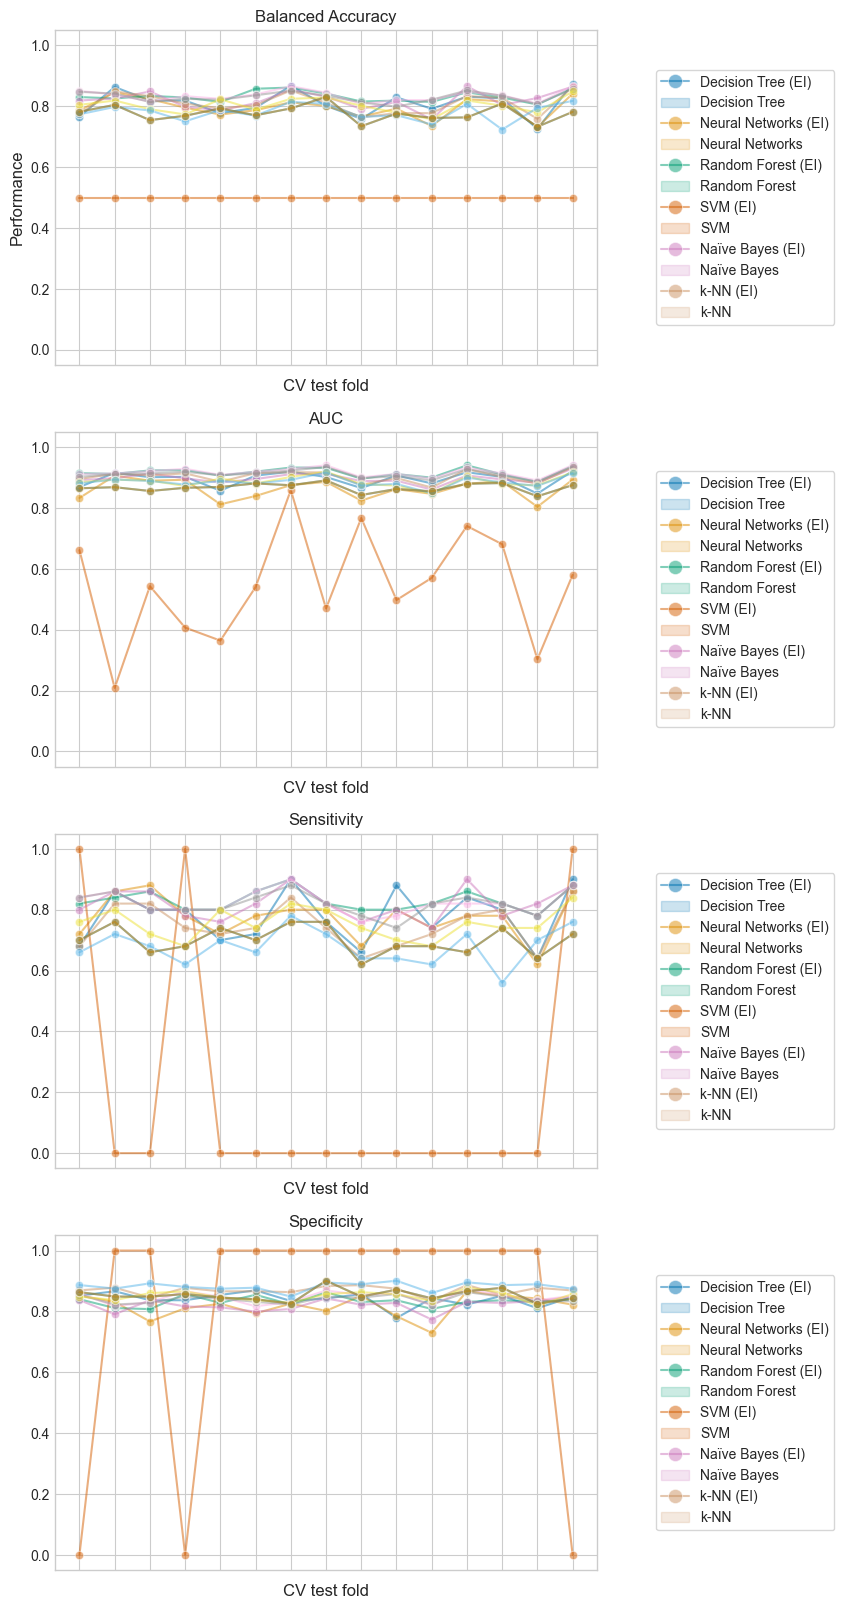

In [144]:
# results_df = df_results_trainning.copy()
results_df = df_results_all.copy()




# plot 30 examples of dependency between cv fold and AUC scores
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    4,1,
    figsize=(7,20), 
    sharex=False, 
    sharey=True
)

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_balanced_accuracy")

g = sns.lineplot(
    ax=ax1,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax1.set_xlabel("CV test fold", size=12, labelpad=10)
ax1.set_ylabel("Performance", size=12)
ax1.tick_params(bottom=True, labelbottom=False)
ax1.set_title('Balanced Accuracy')

ax1.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_auc")
g = sns.lineplot(
    ax=ax2,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax2.set_xlabel("CV test fold", size=12, labelpad=10)
ax2.tick_params(bottom=True, labelbottom=False)
ax2.set_title('AUC')

ax2.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_sensitivity")
g = sns.lineplot(
    ax=ax3,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax3.set_xlabel("CV test fold", size=12, labelpad=10)
ax3.tick_params(bottom=True, labelbottom=False)
ax3.set_title('Sensitivity')

ax3.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_specificity")
g = sns.lineplot(
    ax=ax4,
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="colorblind",
    marker="o",
    alpha=0.5,
)
ax4.set_xlabel("CV test fold", size=12, labelpad=10)
ax4.tick_params(bottom=True, labelbottom=False)
ax4.set_title('Specificity')

ax4.legend(results_df.Algorithm.values)
sns.move_legend(g, "center right", bbox_to_anchor=(1.45, 0.5), frameon=True, markerscale=1.7,)


plt.show()

# # print correlation of Bal Acc scores across folds
# print(f"Correlation of models:")
# df_corr = pd.DataFrame(model_scores.transpose().corr())
# # display(df_corr)
# sns.heatmap(data=df_corr)

In [145]:

# create df of model scores ordered by performance
model_scores_balanced_accuracy = results_df.filter(regex=r"Algorithm|split\d*_test_balanced_accuracy")
model_scores_auc = results_df.filter(regex=r"Algorithm|split\d*_test_auc")
model_scores_sensitivity = results_df.filter(regex=r"Algorithm|split\d*_test_sensitivity")
model_scores_specificity = results_df.filter(regex=r"Algorithm|split\d*_test_specificity")

model_scores = model_scores_balanced_accuracy.copy()

# Implement Bonferroni correction

## Example comparing the 2 first models

In [146]:
model_scores.iloc[0].values  

model_1_scores = model_scores.iloc[0].values  
model_2_scores = model_scores.iloc[1].values  

differences = model_1_scores[1:-1] - model_2_scores[1:-1]
differences

array([-0.019999999999999907, 0.01744186046511631, -0.005014577259475184,
       0.0231195335276968, 0.004577259475218587, 0.007790697674418534,
       0.05436046511627912, 0.00040816326530612734, -0.00708454810495629,
       0.037084548104956205, 0.0566860465116279, 0.008197674418604639,
       0.010000000000000009, -0.006034985422740613], dtype=object)

## Is the first model significantly better than the second?
### Alpha level at p-value = $0.05$

In [147]:
model_1_scores = model_scores.iloc[0].values  
model_2_scores = model_scores.iloc[1].values  

model_1_name = model_1_scores[0]
model_2_name = model_2_scores[0]

differences = model_1_scores[1:-1] - model_2_scores[1:-1]

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cv.split(X_train, y_train))[0][0])
n_test = len(list(cv.split(X_train, y_train))[0][1])

t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)
print(f"{model_1_name} vs. {model_2_name}:\n  Corrected t-value: {t_stat:.3f}\n  Corrected p-value: {p_val:.3f}")

if p_val <= 0.05:
    print('  -> The corrected t-test concludes that the first model IS significantly better than the second')
else:
    print('  -> The corrected t-test concludes that the first model IS NOT significantly better than the second')


Decision Tree (EI) vs. Decision Tree:
  Corrected t-value: 1.000
  Corrected p-value: 0.168
  -> The corrected t-test concludes that the first model IS NOT significantly better than the second


# Comparing two models: Bayesian approach
### In contrast with the previous Frequentist Approach, we can compute the probability that one model is better than the other.



In [148]:
# initialize random variable
t_post = t(
    df, 
    loc=np.mean(differences), 
    scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
)



better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_1_name} being more accurate than "
    f"{model_2_name}: {better_prob:.3f}"
)
print(
    f"Probability of {model_2_name} being more accurate than "
    f"{model_1_name}: {1 - better_prob:.3f}"
)

Probability of Decision Tree (EI) being more accurate than Decision Tree: 0.832
Probability of Decision Tree being more accurate than Decision Tree (EI): 0.168


# Region of Practical Equivalence

### Sometimes we are interested in determining the probabilities that our models have an $equivalent$ performance

### A naive approach would be to define estimators as practically equivalent when they differ by less than 1% in their accuracy. But we could also define this practical equivalence taking into account the problem we are trying to solve

### In this example we are going to define the Region of Practical Equivalence (ROPE) to be $[-0.01, 0.01]$. That is, we will consider two models as practically equivalent if they differ by less than 1% in their performance.

Probability of Decision Tree (EI) and Decision Tree being practically equivalent at ROPE=1%: 0.361



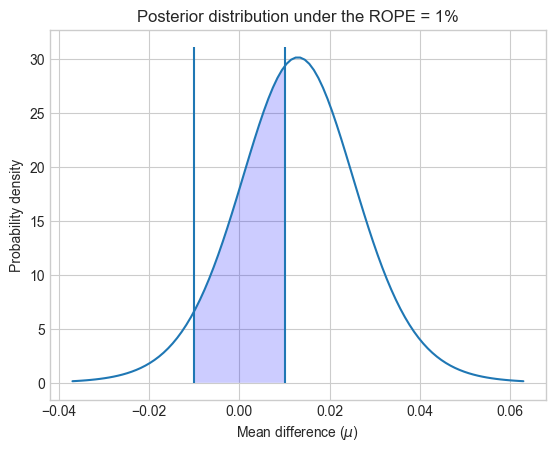

Probability of Decision Tree (EI) and Decision Tree being practically equivalent at ROPE=2%: 0.689



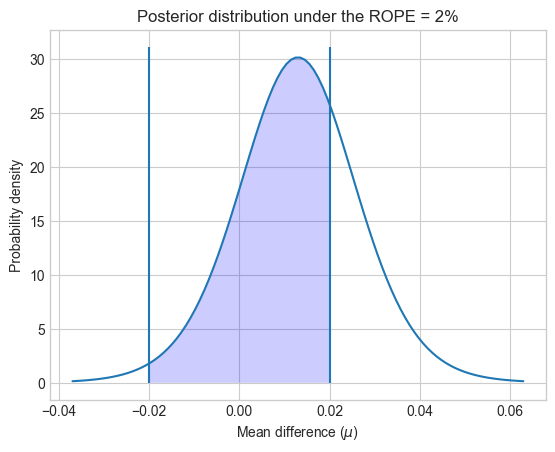

Probability of Decision Tree (EI) and Decision Tree being practically equivalent at ROPE=3%: 0.891



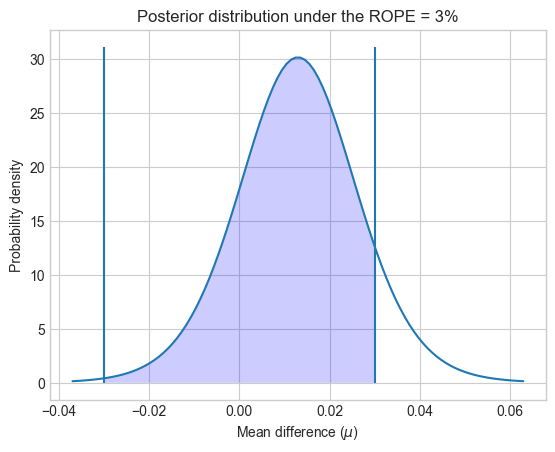

Probability of Decision Tree (EI) and Decision Tree being practically equivalent at ROPE=4%: 0.971



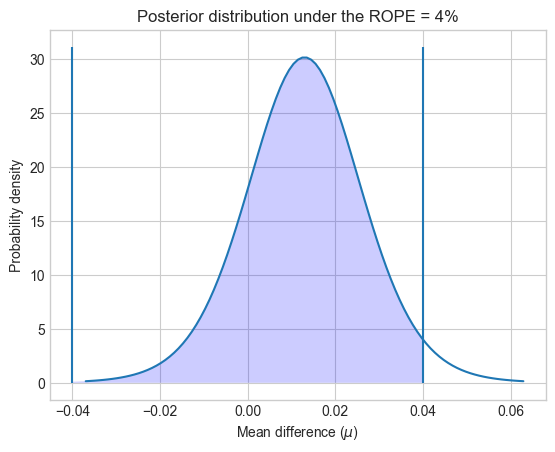

Probability of Decision Tree (EI) and Decision Tree being practically equivalent at ROPE=5%: 0.993



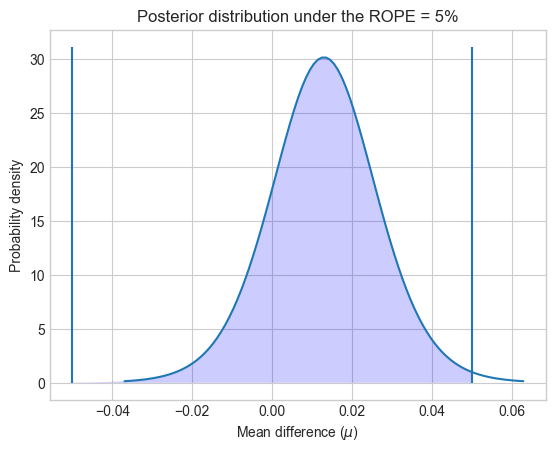

Probability of Decision Tree (EI) and Decision Tree being practically equivalent at ROPE=10%: 1.000



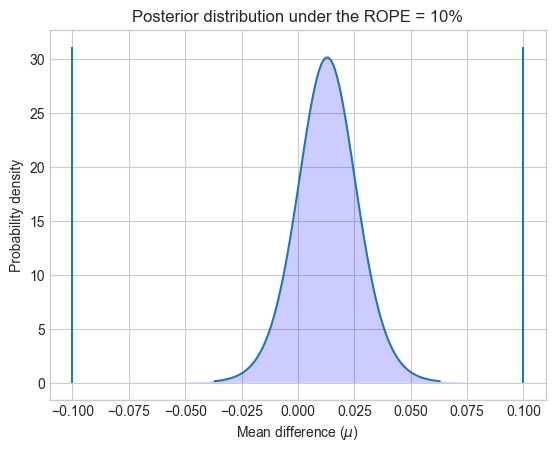

In [149]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

# test several percentages
for percentage in [0.01, 0.02, 0.03, 0.04, 0.05, 0.10]:

    rope_interval = [-percentage, percentage]
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    print(
        f"Probability of {model_1_name} and {model_2_name} "
        f"being practically equivalent at ROPE={rope_interval[1]*100:.0f}%: {rope_prob:.3f}"
    )
    print()
    
    x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

#     plt.figure(figsize=(5,5))
    plt.plot(x, t_post.pdf(x))
#     plt.xticks(np.arange(-0.04, 0.06, 0.01))
    plt.vlines([-percentage, percentage], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
    plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
    plt.ylabel("Probability density")
    plt.xlabel(r"Mean difference ($\mu$)")
    plt.title(f"Posterior distribution under the ROPE = {rope_interval[1]*100:.0f}%")
    plt.show()

# The Bayesian estimation approach also allows us to compute how uncertain we are about our estimation of the difference. 

### This can be calculated using credible intervals. For a given probability, they show the range of values that the estimated quantity, in our case the mean difference in performance, can take. 

### For example, a 50% credible interval $[x, y]$ tells us that there is a 50% probability that the true (mean) difference of performance between models is between x and y.

### Let’s determine the credible intervals of our data using 50%, 75% and 95%:

In [150]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,0.003972,0.021962
0.75,-0.002644,0.028578
0.95,-0.015041,0.040974


As shown in the table, there is a 50% probability that the true mean difference between models will be between 0.000625 and 0.032204, 70% probability that it will be between -0.012697 and 0.044277, and 95% probability that it will be between -0.035319 and 0.066898.



# Pairwise comparison of all models: frequentist approach

### We could also be interested in comparing the performance of all our models evaluated with GridSearchCV. In this case we would be running our statistical test multiple times, which leads us to the multiple comparisons problem.

### There are many possible ways to tackle this problem, but a standard approach is to apply a $Bonferroni$ $correction$. Bonferroni can be computed by multiplying the p-value by the number of comparisons we are testing.

### Let’s compare the performance of the models using the corrected t-test:

#### SO, we observe that after correcting for multiple comparisons, which model that significantly differs from each other

In [151]:
models_scores = [
    ['Balanced Accuracy', model_scores_balanced_accuracy.copy()],
    ['Sensitivity', model_scores_sensitivity.copy()],
    ['Specificity', model_scores_specificity.copy()],
    ['AUC', model_scores_auc.copy()],

]


for algo_name, model_scores in models_scores:

    utils.print_string_with_separators(algo_name)
    
    # set Algorithm name as DF index
    model_scores.set_index('Algorithm', inplace=True)


    n_comparisons = factorial(len(model_scores)) / (
        factorial(2) * factorial(len(model_scores) - 2)
    )


    pairwise_t_test = []

    for model_i, model_k in combinations(range(len(model_scores)), 2):

        model_i_scores = model_scores.iloc[model_i].values
        model_k_scores = model_scores.iloc[model_k].values
        
        differences = model_i_scores - model_k_scores
        
        t_stat, p_val = utils_exec_models_new.compute_corrected_ttest(differences, df, n_train, n_test)

        p_val *= n_comparisons  # implement Bonferroni correction

        # Bonferroni can output p-values higher than 1
        p_val = 1 if p_val > 1 else p_val

        model_1 = model_scores.index[model_i]
        model_2 = model_scores.index[model_k]
        pairwise_t_test.append(
            [model_1, model_2, t_stat, p_val, (p_val<=0.05),
            (model_1.split('(')[0].strip() == model_2.split('(')[0].strip())
            ]
        )

    pairwise_comp_df = pd.DataFrame(
        pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val", "Is_Superior", "Same_Algorithm"]
    ).round(3)


    print(pairwise_comp_df.loc[(pairwise_comp_df.Is_Superior)].to_markdown(index=False))
    print()
    print(pairwise_comp_df.loc[(pairwise_comp_df.Same_Algorithm)].to_markdown(index=False))
    print()
    # print(pairwise_comp_df.to_markdown(index=False))

-----------------
Balanced Accuracy
-----------------
| model_1              | model_2            |   t_stat |   p_val | Is_Superior   | Same_Algorithm   |
|:---------------------|:-------------------|---------:|--------:|:--------------|:-----------------|
| Decision Tree (EI)   | Neural Networks    |   13.023 |   0     | True          | False            |
| Decision Tree        | Neural Networks    |   15.373 |   0     | True          | False            |
| Neural Networks (EI) | Neural Networks    |   33.111 |   0     | True          | True             |
| Neural Networks      | Random Forest (EI) |  -18.596 |   0     | True          | False            |
| Neural Networks      | Random Forest      |  -16.154 |   0     | True          | False            |
| Neural Networks      | SVM (EI)           |  -32.002 |   0     | True          | False            |
| Neural Networks      | SVM                |  -33.049 |   0     | True          | False            |
| Neural Networks      | Naï

# Pairwise comparison of all models: Bayesian approach¶

### When using Bayesian estimation to compare multiple models, we don’t need to correct for multiple comparisons (for reasons why see [4]).

### We can carry out our pairwise comparisons the same way as in the first section:

In [143]:
models_scores = [
    ['Balanced Accuracy', model_scores_balanced_accuracy.copy()],
#     ['Sensitivity', model_scores_sensitivity.copy()],
#     ['Specificity', model_scores_specificity.copy()],
#     ['AUC', model_scores_auc.copy()],

]

pairwise_bayesian = []
pairwise_bayesian_df = pairwise_comp_df.copy()

rope_interval = [-0.05, 0.05]


for algo_name, model_scores in models_scores:

    utils.print_string_with_separators(algo_name)
    # set Algorithm name as DF index
    model_scores.set_index('Algorithm', inplace=True)


    for model_i, model_k in combinations(range(len(model_scores)), 2):
        model_i_scores = model_scores.iloc[model_i].values
        model_k_scores = model_scores.iloc[model_k].values
        
        differences = model_i_scores - model_k_scores

        t_post = t(
            df, loc=np.mean(differences), scale=utils_exec_models_new.corrected_std(differences, n_train, n_test)
        )
        
        worse_prob = t_post.cdf(rope_interval[0])
        better_prob = 1 - t_post.cdf(rope_interval[1])
        rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

        pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

    pairwise_bayesian_df_aux = pd.DataFrame(
        pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
    ).round(3)

    
    pairwise_bayesian_df = pairwise_bayesian_df.join(pairwise_bayesian_df_aux)
#     display(pairwise_bayesian_df)
    
    display(pairwise_bayesian_df.loc[(pairwise_bayesian_df.Is_Superior)]) #.to_markdown(index=False))
    print()
    display(pairwise_bayesian_df.loc[(pairwise_bayesian_df.Same_Algorithm)]) #.to_markdown(index=False))
    print()
    


-----------------
Balanced Accuracy
-----------------


/home/papaiz/anaconda3/envs/phd/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


,model_1,model_2,t_stat,p_val,Is_Superior,Same_Algorithm,worse_prob,better_prob,rope_prob
28,Neural Networks (EI),k-NN (EI),5.911,0.002,True,False,0.0,0.426,0.574
29,Neural Networks (EI),k-NN,5.911,0.002,True,False,0.0,0.426,0.574
49,Random Forest,k-NN (EI),4.223,0.033,True,False,0.0,0.070,0.929
50,Random Forest,k-NN,4.223,0.033,True,False,0.0,0.070,0.929
54,SVM (EI),k-NN (EI),5.584,0.003,True,False,0.0,0.540,0.460
55,SVM (EI),k-NN,5.584,0.003,True,False,0.0,0.540,0.460
58,SVM,k-NN (EI),5.336,0.004,True,False,0.0,0.371,0.628
59,SVM,k-NN,5.336,0.004,True,False,0.0,0.371,0.628


,model_1,model_2,t_stat,p_val,Is_Superior,Same_Algorithm,worse_prob,better_prob,rope_prob
0,Decision Tree (EI),Decision Tree,1.623,1.000,False,True,0.006,0.075,0.918
21,Neural Networks (EI),Neural Networks,2.960,0.365,False,True,0.000,1.000,0.000
38,Random Forest (EI),Random Forest,-0.998,1.000,False,True,0.007,0.060,0.933
51,SVM (EI),SVM,2.457,0.951,False,True,0.000,0.000,1.000
60,Naïve Bayes (EI),Naïve Bayes,0.484,1.000,False,True,0.000,0.002,0.998
65,k-NN (EI),k-NN,0.000,1.000,False,True,NaN,NaN,NaN
